In [1]:
%load_ext autoreload
%autoreload 2

import polars as pl
import networkx as nx
import numpy as np
import torch

from src.base_classes.omic_data_loader import OmicDataLoader
from src.data_managers.concat import CatOmicDataManager
from src.data_managers.sample_graph import SampleGraphDataManager

from src.gnn_utils.interactions import (
    get_mirna_genes_circrna_interactions,
    get_mirna_gene_interactions,
    gg_interactions,
    pp_interactions,
    tf_links
)

In [18]:
mrna_loader = OmicDataLoader(
    data_dir="mds_data/splits_74_risk/mrna",
)
mirna_loader = OmicDataLoader(
    data_dir="mds_data/splits_74_risk/mirna_genes",
)
circrna_loader = OmicDataLoader(
    data_dir="mds_data/splits_74_risk/circrna",
)
# pirna_loader = OmicDataLoader(
#     data_dir="mds_data/splits_74/pirna",
# )
te_loader = OmicDataLoader(
    data_dir="mds_data/splits_74_risk/te_counts",
)

omic_data_loaders = {
    "mrna": mrna_loader,
    # "mirna": mirna_loader,
    # "circrna": circrna_loader,
    # # "pirna": pirna_loader,
    # "te": te_loader,
}
odm = CatOmicDataManager(omic_data_loaders, n_splits=5)

In [154]:
from src.evals.xgboost import XGBoostEvaluator

xgb_eval = XGBoostEvaluator(
    data_manager=odm,
    n_trials=80,
    verbose=True,
)
_ = xgb_eval.evaluate()
xgb_eval.print_best_results()
xgb_eval.print_best_parameters()
# xgb_eval.save_results(results_file=save_folder, row_name="XGBoost")

[I 2024-12-16 16:27:48,484] A new study created in memory with name: no-name-e24b02fd-2df9-4d74-9c81-7491f7ec467d
[I 2024-12-16 16:27:48,547] Trial 0 finished with value: 0.49764519230326676 and parameters: {'booster': 'gblinear', 'lambda': 0.08816818936671046, 'alpha': 8.708475261918125e-08}. Best is trial 0 with value: 0.49764519230326676.
[I 2024-12-16 16:27:48,611] Trial 1 finished with value: 0.454051219036375 and parameters: {'booster': 'gblinear', 'lambda': 1.1945522536154498e-05, 'alpha': 1.4276665102341759e-05}. Best is trial 0 with value: 0.49764519230326676.
[I 2024-12-16 16:27:48,741] Trial 2 finished with value: 0.21534604040404037 and parameters: {'booster': 'dart', 'lambda': 0.41312494896934576, 'alpha': 0.09601118966708615, 'max_depth': 6, 'eta': 0.0019777739132768794, 'gamma': 0.22722917465695128, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00019021038826133902, 'skip_drop': 0.006300767171403498}. Best is trial 0 with

New best score: 0.498
Best model performance:
Accuracy: 0.795 ± 0.064
F1 Macro: 0.791 ± 0.061
F1 Weighted: 0.792 ± 0.063
[{'acc': 0.7272727272727273, 'f1_macro': np.float64(0.7272727272727273), 'f1_weighted': np.float64(0.7272727272727273)}, {'acc': 0.8181818181818182, 'f1_macro': np.float64(0.8166666666666667), 'f1_weighted': np.float64(0.8181818181818182)}, {'acc': 0.7272727272727273, 'f1_macro': np.float64(0.7272727272727273), 'f1_weighted': np.float64(0.7272727272727273)}, {'acc': 0.9, 'f1_macro': np.float64(0.8901098901098901), 'f1_weighted': np.float64(0.8967032967032967)}, {'acc': 0.8, 'f1_macro': np.float64(0.7916666666666667), 'f1_weighted': np.float64(0.7916666666666667)}]


[I 2024-12-16 16:27:48,838] Trial 3 finished with value: 0.21534604040404037 and parameters: {'booster': 'gbtree', 'lambda': 0.11497459024365182, 'alpha': 0.0001902412347384584, 'max_depth': 4, 'eta': 0.019134470502336753, 'gamma': 0.005779377993448926, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.49764519230326676.
[I 2024-12-16 16:27:48,940] Trial 4 finished with value: 0.21534604040404037 and parameters: {'booster': 'gbtree', 'lambda': 2.5451701354784127e-06, 'alpha': 0.002316161045415025, 'max_depth': 2, 'eta': 0.0007505718969214737, 'gamma': 2.196972621341745e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.49764519230326676.
[I 2024-12-16 16:27:49,008] Trial 5 finished with value: 0.4102701493067927 and parameters: {'booster': 'gbtree', 'lambda': 0.0001133881007512582, 'alpha': 2.2425819013481e-05, 'max_depth': 1, 'eta': 0.20853625270345477, 'gamma': 1.462509717533428e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.49764519230326676.
[

Best model performance:
Accuracy: 0.795 ± 0.064
F1 Macro: 0.791 ± 0.061
F1 Weighted: 0.792 ± 0.063
Best hyperparameters:
{'booster': 'gblinear', 'lambda': 0.08816818936671046, 'alpha': 8.708475261918125e-08}


In [20]:
from src.evals.mogonet import MOGONETEvaluator

mogonet_eval = MOGONETEvaluator(
    data_manager=SampleGraphDataManager(
        omic_data_loaders=omic_data_loaders,
        n_splits=5,
        params={
            "graph_style": "threshold",
            "self_connections": True,
            "avg_degree": 8,
        },
    ),
    n_trials=1,
    params={
        "encoder_hidden_channels": {
            "mrna": 32,
            "mirna": 32,
            "circrna": 32,
            "te": 32,
        },
        "encoder_type": "gat",
        "dropout": 0.1,
        "integrator_type": "attention", # vcdn seems to work better on mds disease
        "integration_in_dim": 16,
        "vcdn_hidden_channels": 16,
        "epochs": 250,
        "log_interval": 251,
    },
    save_model_path="mogonet_risk_best_models/model",
)
mogonet_eval.in_channels, mogonet_eval.omic_names
mogonet_eval.evaluate()

[I 2024-12-18 23:20:14,269] A new study created in memory with name: no-name-567c9a0d-3bd0-44f4-9326-af38e93cba99


Using: attention integrator
metrics (0.6226415094339622, np.float64(0.5146520146520146), np.float64(0.5362499136084042))
score 0.4200657390087427
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
metrics (0.6981132075471698, np.float64(0.6418918918918919), np.float64(0.6552779194288627))
score 0.7028104137921743
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])
metrics (0.7924528301886793, np.float64(0.7847914359542266), np.float64(0.788622133071453))
score 0.7272727273727273
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
metrics (0.8867924528301887, np.float64(0.8847826086956522), np.float64(0.8862182116488926))
score 0.8166657297516677
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0])
Using: attention integrator
metrics (0.5660377358490566, np.float64(0.39802469135802465), np.float64(0.42802702073142324))
score 0.4200657390087427
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
metrics (0.6037735849056604, np.float64(0.5015673981191222), np.float64(0.522860353699651))
score 0.5781383137274039
tensor([0, 1, 0, 0, 0, 0, 

[I 2024-12-18 23:20:22,544] Trial 0 finished with value: 0.5708039754384809 and parameters: {}. Best is trial 0 with value: 0.5708039754384809.


New best score: 0.571
Best model performance:
Accuracy: 0.831 ± 0.035
F1 Macro: 0.828 ± 0.032
F1 Weighted: 0.830 ± 0.034
[{'acc': 0.8181818181818182, 'f1_macro': np.float64(0.8166666666666667), 'f1_weighted': np.float64(0.8151515151515153)}, {'acc': 0.8181818181818182, 'f1_macro': np.float64(0.8166666666666667), 'f1_weighted': np.float64(0.8181818181818182)}, {'acc': 0.8181818181818182, 'f1_macro': np.float64(0.8166666666666667), 'f1_weighted': np.float64(0.8181818181818182)}, {'acc': 0.9, 'f1_macro': np.float64(0.8901098901098901), 'f1_weighted': np.float64(0.8967032967032967)}, {'acc': 0.8, 'f1_macro': np.float64(0.8), 'f1_weighted': np.float64(0.8)}]


{'acc': np.float64(0.8309090909090908),
 'f1_macro': np.float64(0.8280219780219781),
 'f1_weighted': np.float64(0.8296436896436896),
 'acc_std': np.float64(0.035255853508482385),
 'f1_macro_std': np.float64(0.031707946535935436),
 'f1_weighted_std': np.float64(0.03420091037095021)}

In [21]:
feat_importances = mogonet_eval.feature_importance("mogonet_risk_best_models")

fi_sorted = dict(sorted(feat_importances.items(), key=lambda x: abs(x[1]), reverse=True))

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: Acc: 0.8679, F1 Macro: 0.8672, F1 Weighted: 0.8681


 20%|██        | 1/5 [00:01<00:05,  1.46s/it]

Fold 1: Acc: 0.9434, F1 Macro: 0.9431, F1 Weighted: 0.9435


 40%|████      | 2/5 [00:02<00:04,  1.43s/it]

Fold 2: Acc: 0.7547, F1 Macro: 0.7301, F1 Weighted: 0.7378


 60%|██████    | 3/5 [00:04<00:02,  1.43s/it]

Fold 3: Acc: 0.8868, F1 Macro: 0.8858, F1 Weighted: 0.8868


 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]

Fold 4: Acc: 0.9434, F1 Macro: 0.9427, F1 Weighted: 0.9433


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


In [162]:
feat_importances = xgb_eval.get_feature_importances(xgb_eval.best_params)

fi_sorted = dict(sorted(feat_importances.items(), key=lambda x: abs(x[1]), reverse=True))

{'acc': 0.7272727272727273, 'f1_macro': np.float64(0.7272727272727273), 'f1_weighted': np.float64(0.7272727272727273)}
{'ENSG00000239839': [0.0660216361284256, -0.06561287492513657], 'ENSG00000064687': [0.007436187006533146, -0.007854610681533813], 'ENSG00000254995': [-0.04646565392613411, 0.04636714980006218], 'ENSG00000240247': [0.06736958771944046, -0.06594625115394592], 'ENSG00000163221': [0.0728432834148407, -0.07219428569078445], 'ENSG00000206047': [0.06769867986440659, -0.06522583216428757], 'ENSG00000122224': [0.05424657464027405, -0.054517246782779694], 'ENSG00000188153': [-0.08864794671535492, 0.08876623213291168], 'ENSG00000233822': [0.13270708918571472, -0.1314355731010437], 'ENSG00000091181': [0.0439787432551384, -0.041507989168167114], 'ENSG00000138131': [0.0012328404700383544, -0.001692092278972268], 'ENSG00000075275': [0.08584799617528915, -0.08378273248672485], 'ENSG00000106976': [-0.0625431090593338, 0.058794327080249786], 'ENSG00000111249': [0.05534717068076134, -0.0

In [22]:
mrna = pl.read_csv("mds_data/preprocessed_74/mrna.csv")
mirna = pl.read_csv("mds_data/preprocessed_74/mirna_genes.csv")

mrna_gene = mrna.select("GENE_NAME", "GENE_ID")
mirna_gene = mirna.select("GENE_NAME", "GENE_ID")

# create one big dict to go from id to name
mrna_dict = dict(zip(mrna_gene["GENE_ID"], mrna_gene["GENE_NAME"]))
mirna_dict = dict(zip(mirna_gene["GENE_ID"], mirna_gene["GENE_NAME"]))

# merge the dicts
mrna_dict.update(mirna_dict)

# rename the keys from fi_sorted to the name of the gene if it exists in mrna_dict
fi_nn = {mrna_dict.get(k, k): v for k, v in fi_sorted.items()}

te = pl.read_csv("mds_data/preprocessed_74/te_counts.csv")
te_names = te['TE'].to_list()

# add "TE: " to all te features
te_names = {x : f"TE: {x}" for x in te_names}

# Create a new dictionary with the updated keys
fi_nn = {te_names.get(k, k): v for k, v in fi_nn.items()}

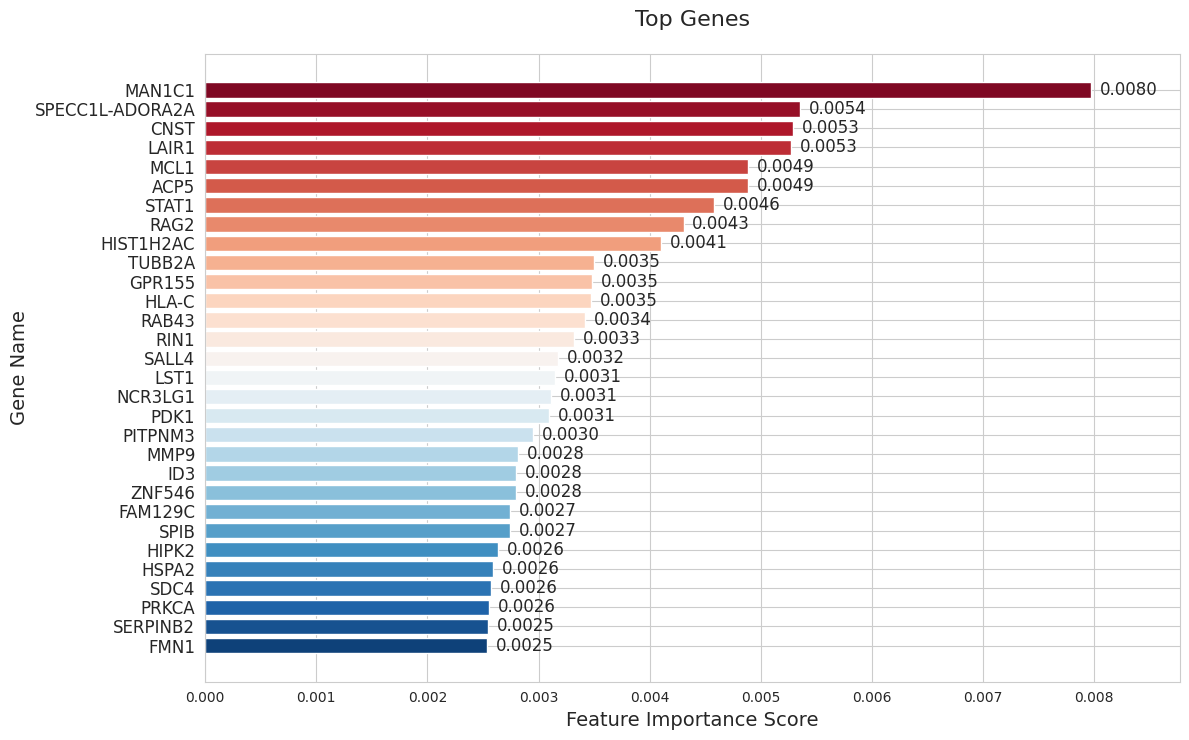

In [23]:
from src.plotting.feature_importance_plot import plot_top_genes

_ = plot_top_genes(
    fi_nn,
    n_genes=30, 
    title="Top Genes",
    save_file="plots/risk/mds_risk.png"
)

- [Arrayed molecular barcoding identifies TNFSF13 as a positive regulator of acute myeloid leukemia-initiating cells](https://pmc.ncbi.nlm.nih.gov/articles/PMC6886409/)
- [PI3K-dependent Reprogramming of Hexokinase Isoforms Regulates B Lymphocyte Metabolism, i.e. HK3 and HK2](https://journals.aai.org/jimmunol/article/204/1_Supplement/151.30/64960/PI3K-dependent-Reprogramming-of-Hexokinase) and [PI3-kinase deletion promotes myelodysplasia by dysregulating autophagy in hematopoietic stem cells, i.e. PI3-kinase is directly linked to myelodysplastic syndrome](https://www.science.org/doi/10.1126/sciadv.ade8222?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)
- [COL24A1 is enhanced in leukemia and myeloma as per protein atlas](https://www.proteinatlas.org/ENSG00000171502-COL24A1/cell+line)
- [GOLGA8S is enchanced in myeloma and also slightly in leukemia as per protein atlas](https://www.proteinatlas.org/ENSG00000261739-GOLGA8S/cell+line#leukemia)

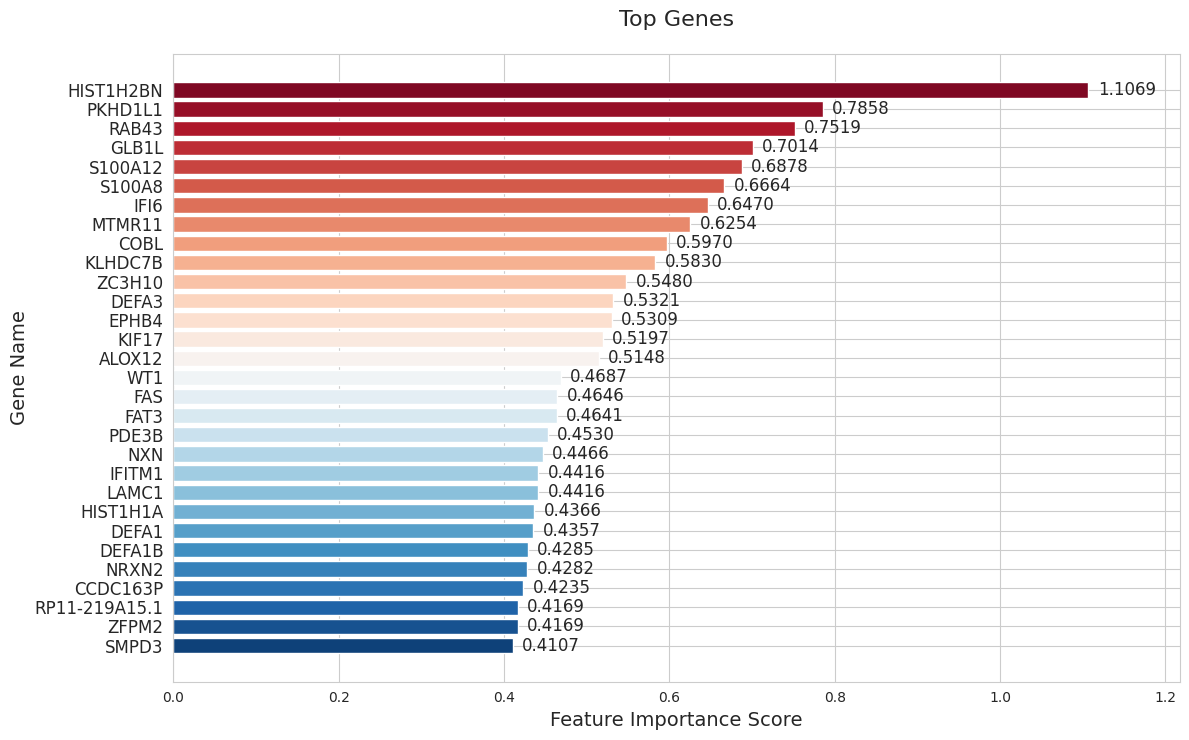

In [165]:
from src.plotting.feature_importance_plot import plot_top_genes

_ = plot_top_genes(
    fi_nn,
    n_genes=30, 
    title="Top Genes",
    save_file="plots/risk/mds_risk_fi_mrna_only.png"
)

In [7]:
mrna_dict = {}
mirna_dict = {}
circrna_dict = {}

# go trough the fi_nn dict and sort it into three lists of mrna, mirna and circrna
for k, v in fi_nn.items():
    if k.startswith("MIR"):
        mirna_dict[k] = v
    elif k.startswith("hsa_circ"):
        circrna_dict[k] = v
    else:
        mrna_dict[k] = v

# keep only top 30 out of each list
n_top_genes = 60
mrna_dict = {k: v for k, v in sorted(mrna_dict.items(), key=lambda item: item[1], reverse=True)[:n_top_genes]}
mirna_dict = {k: v for k, v in sorted(mirna_dict.items(), key=lambda item: item[1], reverse=True)[:n_top_genes]}
circrna_dict = {k: v for k, v in sorted(circrna_dict.items(), key=lambda item: item[1], reverse=True)[:n_top_genes]}

In [8]:
mrna_genes = list(mrna_dict.keys())
mirna_genes = list(mirna_dict.keys())
circrna_names = list(circrna_dict.keys())

gg_A = gg_interactions(mrna_genes, mrna_genes)
pp_A = pp_interactions(mrna_genes, mrna_genes)
tf_links_A = tf_links(
    mrna_genes,
    mrna_genes,
    tflinksdb="interaction_data/TFLink_Homo_sapiens_interactions_SS_simpleFormat_v1.0.tsv",
    # tflinksdb="interaction_data/TFLink_Homo_sapiens_interactions_LS_simpleFormat_v1.0.tsv",
)
mrna_A = torch.logical_or(gg_A, pp_A).logical_or(tf_links_A).int()

mirna_gene_A = get_mirna_gene_interactions(mirna_genes, mrna_genes, mirna_mrna_db="interaction_data/mirna_genes_mrna.csv")

# interactions are in a shape of (mirnas, circrnas)
circrna_mirna_A = get_mirna_genes_circrna_interactions(
    mirna_names=mirna_genes,
    circrna_names=circrna_names,
    mirna_circrna_interactions="interaction_data/circrna_mirna_interactions_mirbase.csv",
)

mrna_A.sum(), mirna_gene_A.sum(), circrna_mirna_A.sum()

(tensor(20), tensor(0.), tensor(0.))

4169


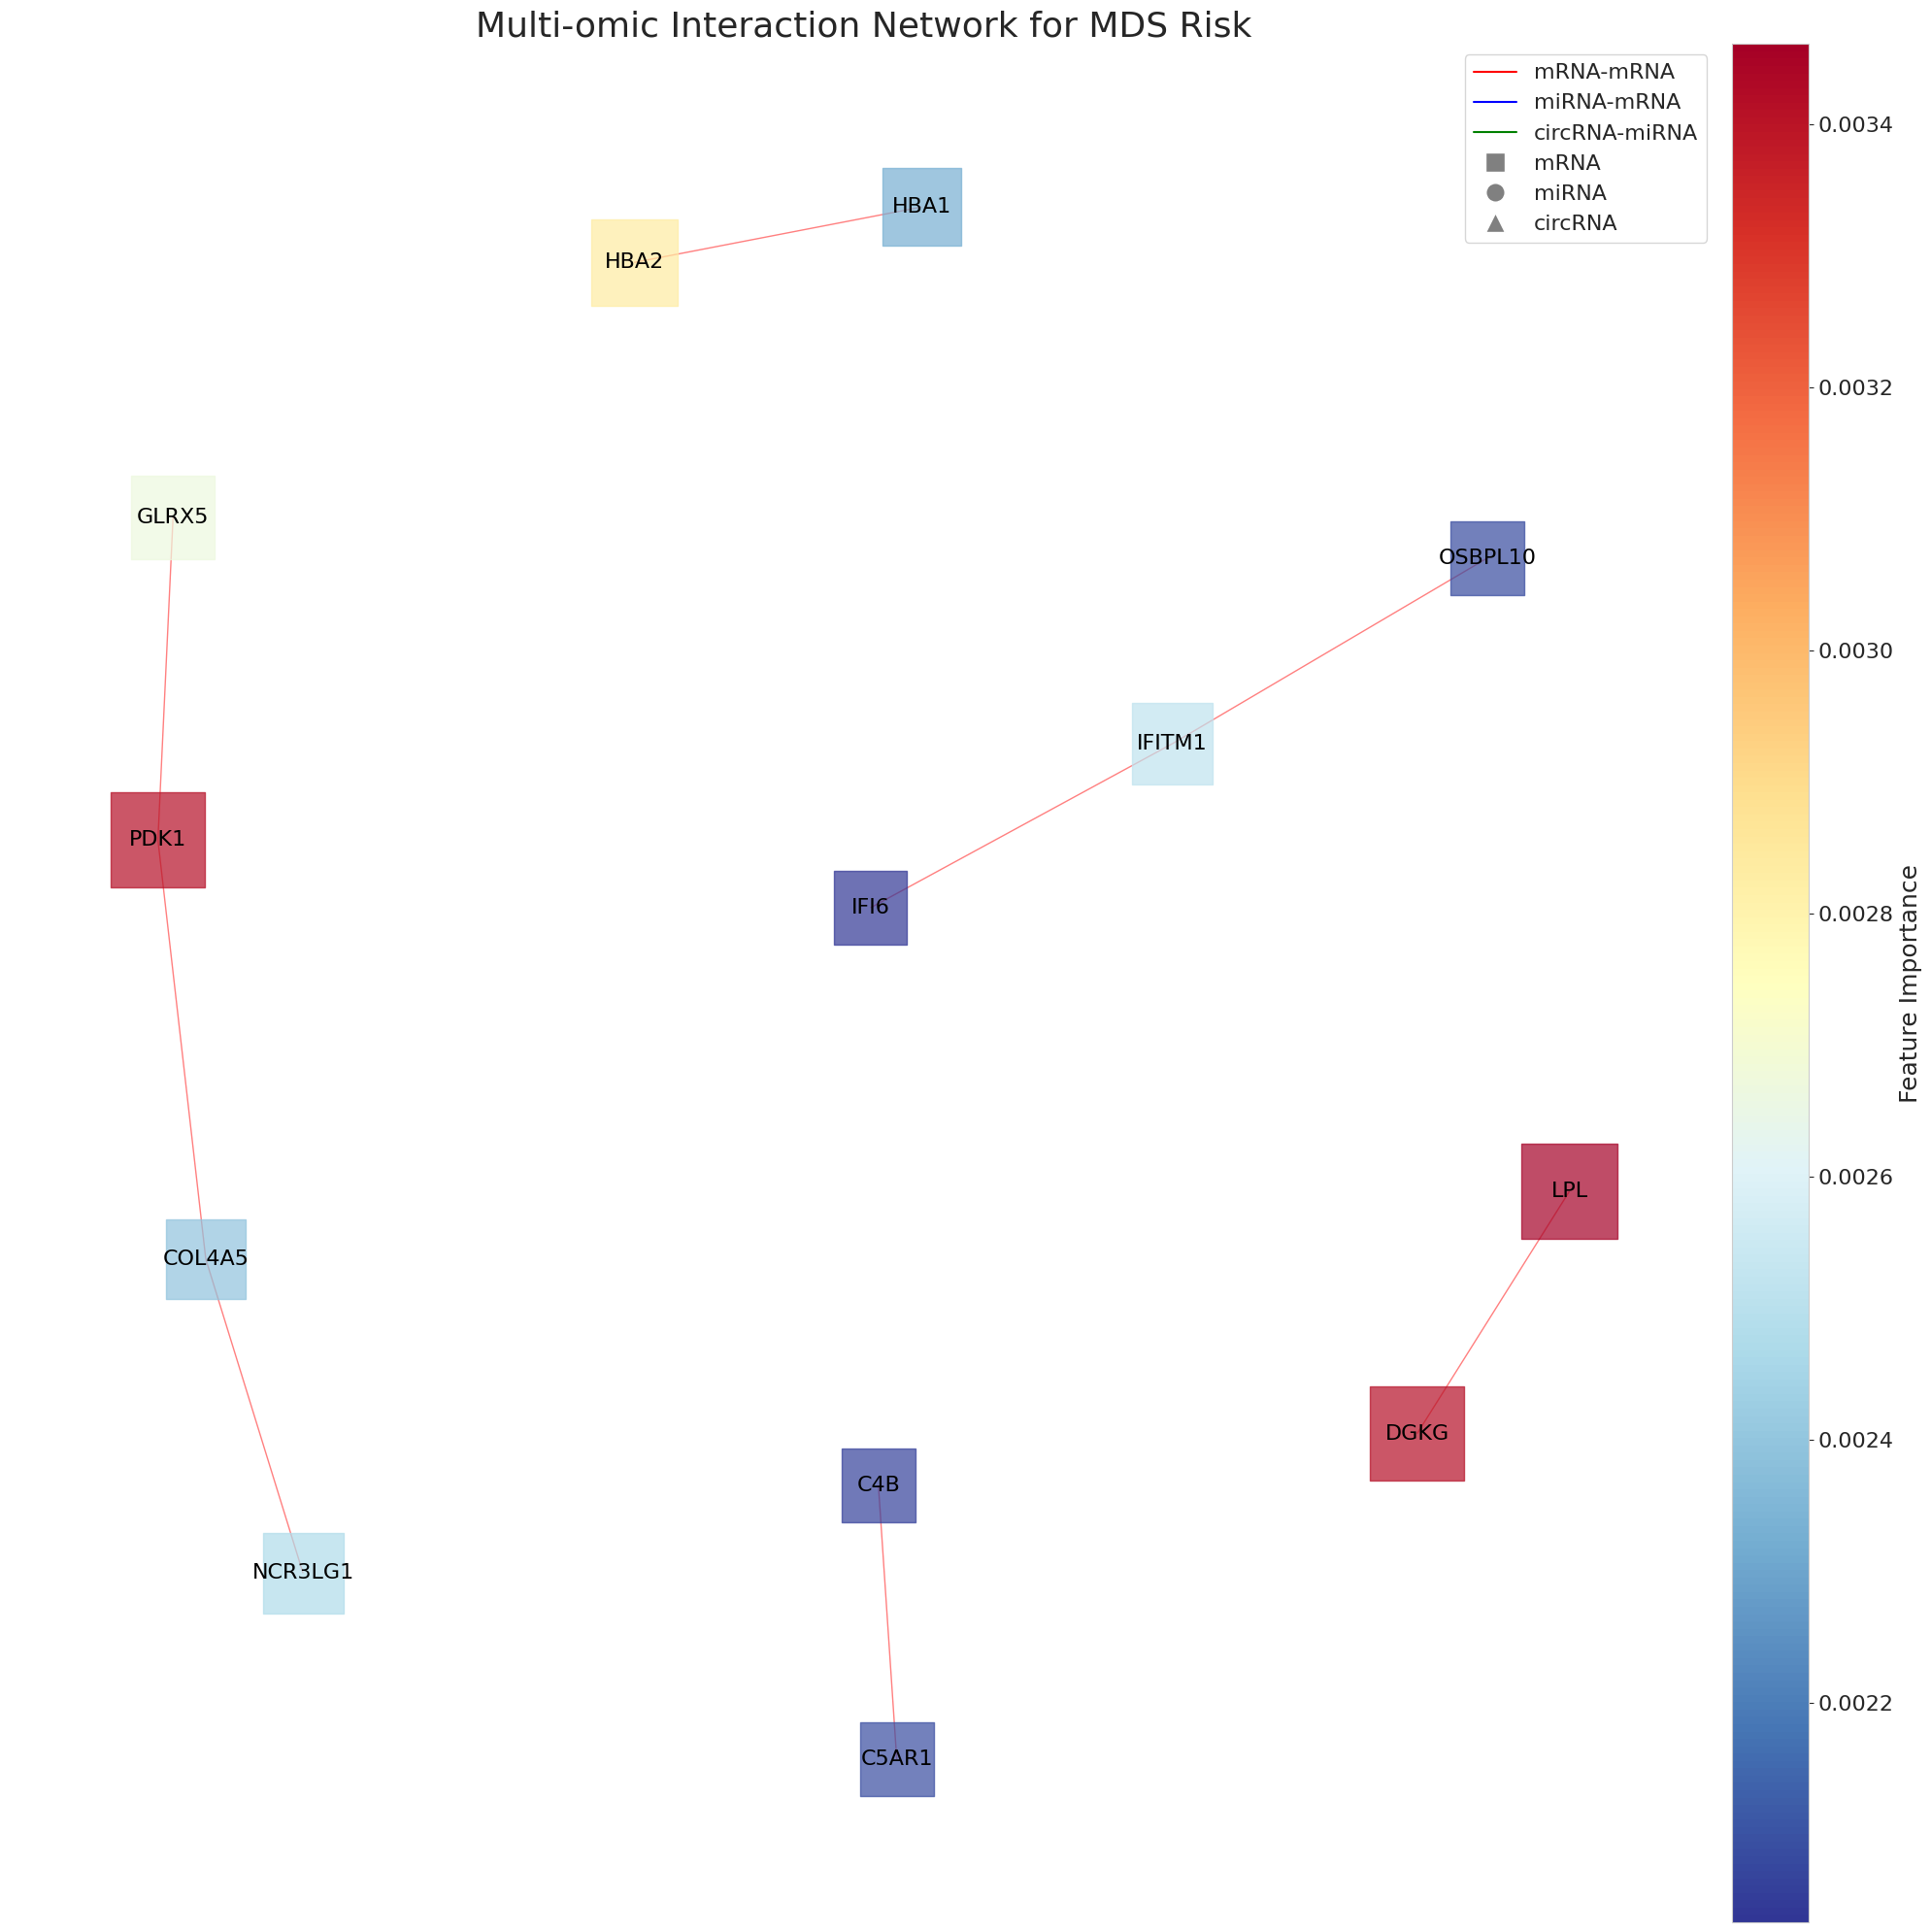

In [9]:
from src.plotting.graph_plotting import create_multi_omic_network, plot_multi_omic_network

# Example usage:
G = create_multi_omic_network(mrna_dict, mirna_dict, circrna_dict, 
                             mrna_A, mirna_gene_A, circrna_mirna_A)

# generate a random number
# seed = 8894 # 7306 - disease
# seed = 4580 # - risk
seed = np.random.randint(0, 10000)
print(seed)
fig = plot_multi_omic_network(
    G,
    seed=seed, 
    title="Multi-omic Interaction Network for MDS Risk",
    figsize=(20,20),
    max_iter=500,
    gravity=1.0,
    jitter_tolerance=2.0,
)
fig.savefig('plots/risk/multi_omic_network_genes_small.png', dpi=400)

- the DEFA gene family which has high scores here has been associated with different types of cancer but not with MDS it seems
- [Whole blood defensin mRNA expression is a predictive biomarker of docetaxel response in castration-resistant prostate cancer](https://pmc.ncbi.nlm.nih.gov/articles/PMC4527520/) 
- [S100A12 is a promising biomarker in papillary thyroid cancer](https://www.nature.com/articles/s41598-020-58534-1)
- [S100A8, S100A9 and S100A12 are strongly correlated with the occurrence and development of cancer](https://onlinelibrary.wiley.com/doi/10.1111/imm.13722)
- [S100A9 induces differentiation of acute myeloid leukemia cells through TLR4](https://pubmed.ncbi.nlm.nih.gov/28137827/)
- [S100 Proteins in Acute Myeloid Leukemia](https://pubmed.ncbi.nlm.nih.gov/30366122/)
- [Roles of Histone Deacetylases in Acute Myeloid Leukemia With Fusion Proteins](https://pmc.ncbi.nlm.nih.gov/articles/PMC8440836/) and [https://eurjmedres.biomedcentral.com/articles/10.1186/s40001-024-02108-8](https://eurjmedres.biomedcentral.com/articles/10.1186/s40001-024-02108-8)
- we have three histone genes here as important features
    - HIST1H2BN 4.245093017816544
    - HIST1H2AC 1.6199357211589813
    - HIST1H1A 1.2683670080441516

In [51]:
fig.savefig('plots/risk/multi_omic_network.png', dpi=400)

<Figure size 640x480 with 0 Axes>

[MiR-570 inhibits cell proliferation and glucose metabolism by targeting IRS1 and IRS2 in human chronic myelogenous leukemia](https://pmc.ncbi.nlm.nih.gov/articles/PMC5478775/)

In [158]:
import gseapy as gp

mrna_dict = {}
mirna_dict = {}
circrna_dict = {}

# go trough the fi_nn dict and sort it into three lists of mrna, mirna and circrna
for k, v in fi_nn.items():
    if k.startswith("MIR"):
        mirna_dict[k] = v
    elif k.startswith("hsa_circ"):
        circrna_dict[k] = v
    else:
        mrna_dict[k] = v

n_top_genes = 100
mrna_dict_enrich = {k: v for k, v in sorted(mrna_dict.items(), key=lambda item: item[1], reverse=True)}
mrna_genes_enrich = list(mrna_dict.keys())[:n_top_genes]
print(len(mrna_genes_enrich))

# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(
    gene_list=mrna_genes_enrich, # or "./tests/data/gene_list.txt",
    gene_sets=['BioPlanet_2019','KEGG_2021_Human', 'Elsevier_Pathway_Collection', 'WikiPathways_2024_Human', 'Reactome_Pathways_2024'],
    organism='human',
    outdir=None,
)
# select by Adjusted P-value < 0.05
results = pl.DataFrame(enr.results)
significant_results = (
    results
    .filter(pl.col("Adjusted P-value") < 0.05)
    .select(["Gene_set", "Term", "Adjusted P-value", "Genes"])
    .sort("Adjusted P-value")
)
significant_results = significant_results

with pl.Config(tbl_rows=-1, tbl_cols=-1, tbl_width_chars=200, fmt_str_lengths=1000, set_tbl_formatting='ASCII_FULL'):
    print(significant_results.head(20))

100
shape: (20, 4)
+-----------------------------+------------------------------------------------------------+------------------+----------------------------------------------------------------------------------------+
| Gene_set                    | Term                                                       | Adjusted P-value | Genes                                                                                  |
| ---                         | ---                                                        | ---              | ---                                                                                    |
| str                         | str                                                        | f64              | str                                                                                    |
+================================================================================================================================================================================

In [159]:
# XGBOOST RESULTS

with pl.Config(tbl_rows=-1, tbl_cols=-1, tbl_width_chars=200, fmt_str_lengths=1000, set_tbl_formatting='ASCII_FULL'):
    print(significant_results)

shape: (42, 4)
+-----------------------------+--------------------------------------------------------------------+------------------+--------------------------------------------------------------------------------+
| Gene_set                    | Term                                                               | Adjusted P-value | Genes                                                                          |
| ---                         | ---                                                                | ---              | ---                                                                            |
| str                         | str                                                                | f64              | str                                                                            |
+====================================================================================================================================================================================

In [151]:
# MDS RESULTS

# with pl.Config(tbl_rows=-1, tbl_cols=-1, tbl_width_chars=200, fmt_str_lengths=1000, set_tbl_formatting='ASCII_FULL'):
#     print(significant_results)

shape: (29, 4)
+------------------------+-----------------------------------------------------------------------------+------------------+----------------------------------------------------------------------------+
| Gene_set               | Term                                                                        | Adjusted P-value | Genes                                                                      |
| ---                    | ---                                                                         | ---              | ---                                                                        |
| str                    | str                                                                         | f64              | str                                                                        |
+====================================================================================================================================================================================

In [170]:
import gseapy as gp

mrna_dict = {}
mirna_dict = {}
circrna_dict = {}

# go trough the fi_nn dict and sort it into three lists of mrna, mirna and circrna
for k, v in fi_nn.items():
    if k.startswith("MIR"):
        mirna_dict[k] = v
    elif k.startswith("hsa_circ"):
        circrna_dict[k] = v
    else:
        mrna_dict[k] = v

n_top_genes = 100
mrna_dict_enrich = {k: v for k, v in sorted(mrna_dict.items(), key=lambda item: item[1], reverse=True)}
mrna_genes_enrich = list(mrna_dict.keys())[:n_top_genes]
print(len(mrna_genes_enrich))
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(
    gene_list=mrna_genes_enrich, # or "./tests/data/gene_list.txt",
    gene_sets=[
        "GO_Biological_Process_2023",
        "GO_Molecular_Function_2023",
        "GO_Cellular_Component_2023",
        # "Jensen_DISEASES",
        # "Human_Phenotype_Ontology"
    ],
    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
    outdir=None, # don't write to disk
)

# select by Adjusted P-value < 0.05
results = pl.DataFrame(enr.results)
significant_results = results.filter(pl.col("Adjusted P-value") < 0.05)

significant_results = significant_results.select(["Gene_set", "Term", "Adjusted P-value", "Genes"]).sort("Adjusted P-value")

100


In [171]:
with pl.Config(tbl_rows=-1, tbl_cols=-1, tbl_width_chars=200, fmt_str_lengths=200, set_tbl_formatting='ASCII_FULL'):
    print(significant_results)

shape: (36, 4)
+----------------------------+---------------------------------------------------------------------------+------------------+--------------------------------------------------------------------------+
| Gene_set                   | Term                                                                      | Adjusted P-value | Genes                                                                    |
| ---                        | ---                                                                       | ---              | ---                                                                      |
| str                        | str                                                                       | f64              | str                                                                      |
+====================================================================================================================================================================================